# Análisis de redes Gobiernos Regionales - Empresa (2019 - 2022)

In [3]:
# Ejecuta sólo si necesitas instalar algo (en la mayoría de entornos pandas + openpyxl ya están)
!pip install --quiet openpyxl networkx

import pandas as pd
import networkx as nx

In [5]:
# Cambia el nombre si tu archivo tiene otro nombre
filename = "contratos_2019_2022.xlsx"

# Leemos todo como string para preservar RUCs con ceros a la izquierda
df = pd.read_excel(filename, sheet_name=0, engine="openpyxl", dtype=str)

# Normalizamos nombres de columnas (sin espacios, mayúsculas)
df.columns = df.columns.str.strip()

In [7]:
# Detecta automáticamente columnas que empiecen por "EMPRESA" (case-insensitive)
empresa_cols = [col for col in df.columns if col.upper().startswith("EMPRESA")]

# Asegurarnos que exista REGION
if 'REGION' not in df.columns and 'Region' in df.columns:
    df.rename(columns={'Region':'REGION'}, inplace=True)

# Normalizar REGION como string
df['REGION'] = df['REGION'].astype(str).str.strip()

# Función de limpieza de RUCs (elimina .0 si apareció, quita espacios y strings vacíos)
def clean_ruc(x):
    if pd.isna(x): 
        return None
    s = str(x).strip()
    if s == "" or s.lower() in ["nan", "none"]:
        return None
    # Si apareció como "123456789.0"
    if s.endswith(".0"):
        s = s[:-2]
    return s

# Aplicar limpieza a todas las columnas EMPRESA detected
for c in empresa_cols:
    df[c] = df[c].apply(clean_ruc)

In [9]:
# Si no hay un id de obra, creamos uno (índice)
df = df.reset_index(drop=True)
df['CONTRACT_ID'] = df.index.astype(str)

def empresa_list_from_row(row):
    vals = []
    for c in empresa_cols:
        v = row.get(c)
        if v is None:
            continue
        # preservar orden y unicidad
        if v not in vals:
            vals.append(v)
    return vals

df['EMPRESA_LIST'] = df.apply(empresa_list_from_row, axis=1)

# Opcional: revisar algunas filas
df[['CONTRACT_ID','REGION','EMPRESA_LIST']].head(6)

,CONTRACT_ID,REGION,EMPRESA_LIST
0,0,AMAZONAS,[20270971891]
1,1,AMAZONAS,[20479840688]
2,2,AMAZONAS,"[20561152005, 20487499685]"
3,3,AMAZONAS,[20480427913]
4,4,AMAZONAS,"[20480836252, 20487499685]"
5,5,AMAZONAS,"[20453649840, 20570818644]"


In [11]:
df_exploded = df[['CONTRACT_ID','REGION','EMPRESA_LIST']].explode('EMPRESA_LIST')
df_exploded = df_exploded.rename(columns={'EMPRESA_LIST':'EMPRESA'})
# quitar filas sin empresa
df_exploded = df_exploded.dropna(subset=['EMPRESA']).reset_index(drop=True)

# Vista rápida
df_exploded.head()

,CONTRACT_ID,REGION,EMPRESA
0,0,AMAZONAS,20270971891
1,1,AMAZONAS,20479840688
2,2,AMAZONAS,20561152005
3,2,AMAZONAS,20487499685
4,3,AMAZONAS,20480427913


In [13]:
bipartite_edgelist = (
    df_exploded
    .groupby(['REGION','EMPRESA'], dropna=False)
    .size()
    .reset_index(name='CONTRACTS')
)

# Mostrar top filas
bipartite_edgelist.sort_values('CONTRACTS', ascending=False).head(10)

,REGION,EMPRESA,CONTRACTS
1087,LORETO,20393633990,13
174,ANCASH,20530592520,11
1131,LORETO,20528115897,11
291,ANCASH,20571395364,10
1125,LORETO,20493874587,9
667,HUANUCO,20489747244,9
275,ANCASH,20569181756,9
1115,LORETO,20493537742,9
673,HUANUCO,20510591829,8
250,ANCASH,20542049228,8


In [15]:
bipartite_matrix = bipartite_edgelist.pivot(index='REGION', columns='EMPRESA', values='CONTRACTS').fillna(0).astype(int)

# Guardar a CSV para usar fuera de Python
bipartite_edgelist.to_csv("bipartite_edgelist.csv", index=False)
bipartite_matrix.to_csv("bipartite_matrix.csv")

# Resumen
print("Edgelist (REGION - EMPRESA - CONTRACTS):", bipartite_edgelist.shape)
print("Matriz bipartita (REGION x EMPRESA):", bipartite_matrix.shape)

Edgelist (REGION - EMPRESA - CONTRACTS): (1470, 3)
Matriz bipartita (REGION x EMPRESA): (25, 1211)


In [17]:
B = nx.Graph()
regions = bipartite_edgelist['REGION'].unique().tolist()
empresas = bipartite_edgelist['EMPRESA'].unique().tolist()

B.add_nodes_from(regions, bipartite=0)
B.add_nodes_from(empresas, bipartite=1)

for _, row in bipartite_edgelist.iterrows():
    B.add_edge(row['REGION'], row['EMPRESA'], weight=int(row['CONTRACTS']))

# Ejemplo: grado (suma de pesos) de una región
region_example = regions[0]
print("Grado (número de contratos totales) de", region_example, ":", sum(d['weight'] for u,v,d in B.edges(region_example, data=True)))

Grado (número de contratos totales) de AMAZONAS : 121


In [21]:
import matplotlib.pyplot as plt

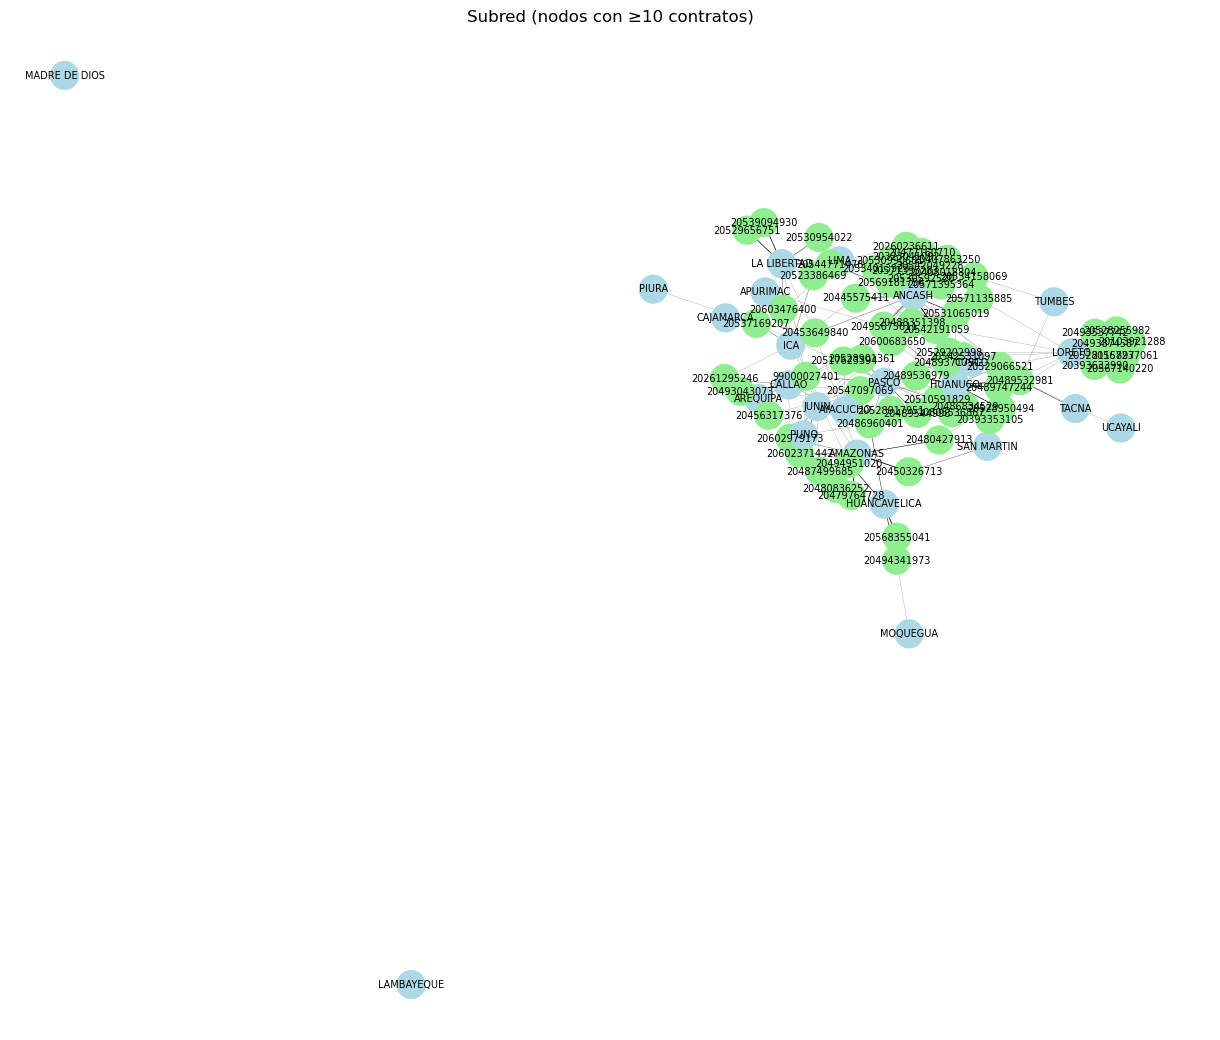

In [29]:
# Filtrar nodos con más de 5 contratos
deg = dict(B.degree(weight="weight"))
sub_nodes = [n for n, d in deg.items() if d >= 5]
H = B.subgraph(sub_nodes)

plt.figure(figsize=(12,10))
pos = nx.spring_layout(H, seed=42, weight="weight")
nx.draw(H, pos,
    with_labels=True,
    node_size=400,
    node_color=["lightblue" if n in regions else "lightgreen" for n in H.nodes()],
    width=[d["weight"]*0.1 for _,_,d in H.edges(data=True)],
    font_size=7
)
plt.title("Subred (nodos con ≥10 contratos)")
plt.show()

## Gráfico de redes para empresas que ganaron 5 o más contratos

In [31]:
!pip install pyvis
from pyvis.network import Network

# Crear red de pyvis a partir del subgrafo H
net = Network(notebook=True, width="1000px", height="700px", bgcolor="white", font_color="black")

# Agregar nodos
for node, data in H.nodes(data=True):
    color = "lightblue" if node in regions else "lightgreen"
    net.add_node(node, label=node, color=color)

# Agregar aristas con pesos
for u, v, d in H.edges(data=True):
    net.add_edge(u, v, value=d["weight"], title=f"Contratos: {d['weight']}")

# Mostrar en notebook
net.show("subred_interactiva.html")

subred_interactiva.html


## Análisis de la red bipartita

In [34]:
import networkx as nx

# ---- 1. Densidad ----
density_bip = nx.density(B)
print("Densidad bipartita:", density_bip)

# ---- 2. Grado (degree) ----
# Considerando pesos = número de contratos
degree_bip = dict(B.degree(weight="weight"))
print("Ejemplo de grados:", list(degree_bip.items())[:10])

# ---- 3. Betweenness centrality ----
betweenness_bip = nx.betweenness_centrality(B, weight="weight", normalized=True)
print("Ejemplo de betweenness:", list(betweenness_bip.items())[:10])

# ---- 4. Closeness centrality ----
closeness_bip = nx.closeness_centrality(B, distance=lambda u,v,d: 1/d["weight"])
print("Ejemplo de closeness:", list(closeness_bip.items())[:10])

# ---- 5. Alcance (reachability) y distancias ----
# Número de componentes conectados
components = list(nx.connected_components(B))
print("Número de componentes conectados:", len(components))

# Longitud promedio de los caminos en el componente gigante
largest_component = B.subgraph(max(components, key=len)).copy()
avg_path_length = nx.average_shortest_path_length(
    largest_component, weight=lambda u,v,d: 1/d["weight"]
)
print("Longitud promedio de camino (componente gigante):", avg_path_length)

Densidad bipartita: 0.001926024920404072
Ejemplo de grados: [('AMAZONAS', 121), ('ANCASH', 478), ('APURIMAC', 12), ('AREQUIPA', 68), ('AYACUCHO', 31), ('CAJAMARCA', 41), ('CALLAO', 68), ('CUSCO', 27), ('HUANCAVELICA', 108), ('HUANUCO', 210)]
Ejemplo de betweenness: [('AMAZONAS', 0.10386476090651309), ('ANCASH', 0.46894123036780366), ('APURIMAC', 0.01066255669150963), ('AREQUIPA', 0.06963845753159807), ('AYACUCHO', 0.032814079760547), ('CAJAMARCA', 0.032013138758697025), ('CALLAO', 0.06791860535378177), ('CUSCO', 0.03483225745041534), ('HUANCAVELICA', 0.09503688365908534), ('HUANUCO', 0.15495943199550197)]
Ejemplo de closeness: [('AMAZONAS', 0.43209144476617417), ('ANCASH', 0.5786761112885641), ('APURIMAC', 0.3642982546892004), ('AREQUIPA', 0.4018121167179508), ('AYACUCHO', 0.3822239916245785), ('CAJAMARCA', 0.39077263153504477), ('CALLAO', 0.4241371963138444), ('CUSCO', 0.3136961281403917), ('HUANCAVELICA', 0.4276734175777194), ('HUANUCO', 0.5507673232966193)]
Número de componentes con

In [36]:
import pandas as pd
import networkx as nx

# ---- Cálculo de métricas en la red bipartita ----
# Grado (ponderado por número de contratos)
degree_bip = dict(B.degree(weight="weight"))

# Betweenness centrality
betweenness_bip = nx.betweenness_centrality(B, weight="weight", normalized=True)

# Closeness centrality
closeness_bip = nx.closeness_centrality(B, distance=lambda u,v,d: 1/d["weight"])

# Identificar tipo de nodo (REGIÓN o EMPRESA)
node_type = {}
for n in B.nodes():
    if n in regions:
        node_type[n] = "REGION"
    else:
        node_type[n] = "EMPRESA"

# ---- Unir todo en una tabla ----
df_bip_metrics = pd.DataFrame({
    "nodo": list(B.nodes()),
    "tipo": [node_type[n] for n in B.nodes()],
    "grado": [degree_bip[n] for n in B.nodes()],
    "betweenness": [betweenness_bip[n] for n in B.nodes()],
    "closeness": [closeness_bip[n] for n in B.nodes()]
})

# Mostrar primeras filas
df_bip_metrics.head(10)

,nodo,tipo,grado,betweenness,closeness
0,AMAZONAS,REGION,121,0.103865,0.432091
1,ANCASH,REGION,478,0.468941,0.578676
2,APURIMAC,REGION,12,0.010663,0.364298
3,AREQUIPA,REGION,68,0.069638,0.401812
4,AYACUCHO,REGION,31,0.032814,0.382224
5,CAJAMARCA,REGION,41,0.032013,0.390773
6,CALLAO,REGION,68,0.067919,0.424137
7,CUSCO,REGION,27,0.034832,0.313696
8,HUANCAVELICA,REGION,108,0.095037,0.427673
9,HUANUCO,REGION,210,0.154959,0.550767


# Evolución de red año a año

Data en formato largo:
     REGION      FECHA   AÑO   Posicion       EMPRESA
0  AMAZONAS 2020-10-01  2020  EMPRESA_1  2.027097e+10
1  AMAZONAS 2019-11-27  2019  EMPRESA_1  2.047984e+10
2  AMAZONAS 2019-11-12  2019  EMPRESA_1  2.056115e+10
3  AMAZONAS 2019-11-12  2019  EMPRESA_1  2.048043e+10
4  AMAZONAS 2019-11-08  2019  EMPRESA_1  2.048084e+10

Redes bipartitas creadas para los años: [2019, 2020, 2021, 2022]

Proyecciones de empresas creadas por año.


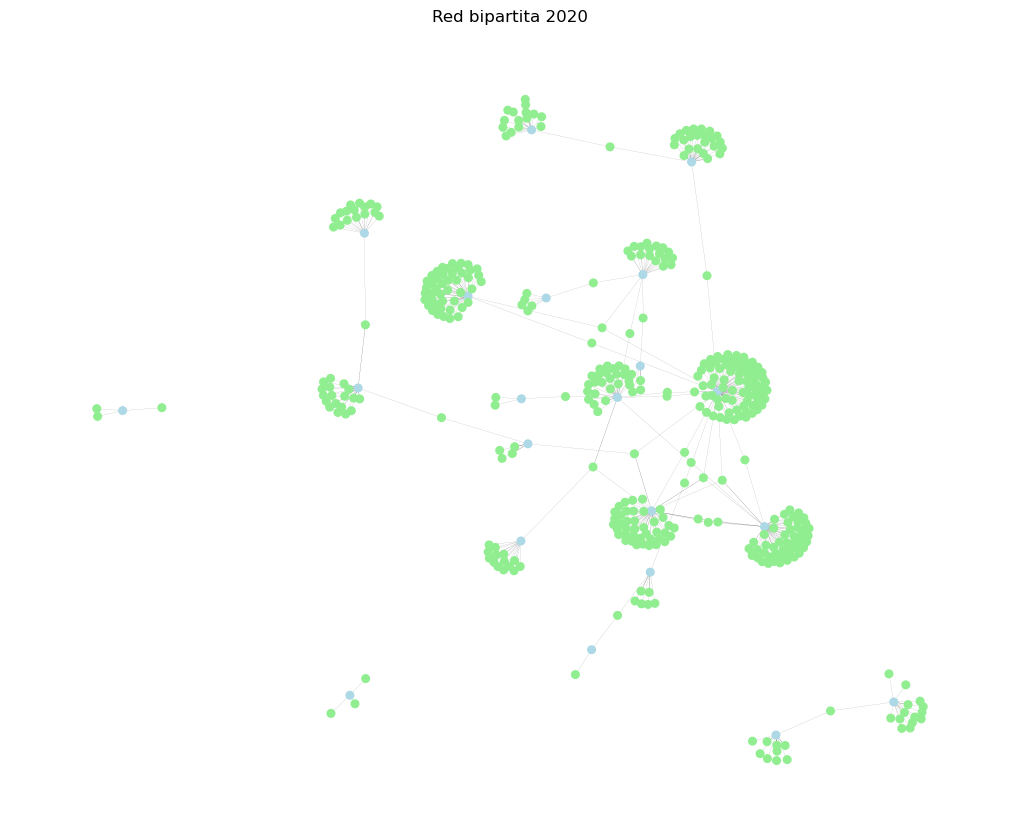

In [41]:
# =============================
# 1. Importar librerías
# =============================
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# =============================
# 2. Cargar el Excel
# =============================
# Asegúrate que el archivo .xlsx esté en la misma carpeta que tu Jupyter
df_obras = pd.read_excel("contratos_2019_2022.xlsx")

# =============================
# 3. Procesar fechas y extraer el año
# =============================
df_obras["FECHA"] = pd.to_datetime(df_obras["FECHA"], dayfirst=True, errors="coerce")
df_obras["AÑO"] = df_obras["FECHA"].dt.year

# =============================
# 4. Pasar de ancho a largo (EMPRESA_1 ... EMPRESA_6 → EMPRESA)
# =============================
empresas_cols = ["EMPRESA_1","EMPRESA_2","EMPRESA_3","EMPRESA_4","EMPRESA_5","EMPRESA_6"]

df_long = df_obras.melt(
    id_vars=["REGION","FECHA","AÑO"],
    value_vars=empresas_cols,
    var_name="Posicion",
    value_name="EMPRESA"
).dropna(subset=["EMPRESA"])  # eliminamos filas donde no hay empresa

print("Data en formato largo:")
print(df_long.head())

# =============================
# 5. Construir redes bipartitas por año
# =============================
redes_por_año = {}

for año, data_año in df_long.groupby("AÑO"):
    B = nx.Graph()
    
    # Nodos
    regiones = data_año["REGION"].unique()
    empresas = data_año["EMPRESA"].unique()
    B.add_nodes_from(regiones, bipartite="region")
    B.add_nodes_from(empresas, bipartite="empresa")
    
    # Aristas (REGION - EMPRESA) con peso = número de contratos
    contratos = data_año.groupby(["REGION","EMPRESA"]).size().reset_index(name="contratos")
    for _, row in contratos.iterrows():
        B.add_edge(row["REGION"], row["EMPRESA"], weight=row["contratos"])
    
    redes_por_año[año] = B

print(f"\nRedes bipartitas creadas para los años: {list(redes_por_año.keys())}")

# =============================
# 6. Proyección monopartita (ejemplo empresas)
# =============================
proyecciones_empresas = {}

for año, B in redes_por_año.items():
    empresas = {n for n,d in B.nodes(data=True) if d["bipartite"]=="empresa"}
    proj = nx.bipartite.weighted_projected_graph(B, empresas)
    proyecciones_empresas[año] = proj

print("\nProyecciones de empresas creadas por año.")

# =============================
# 7. Visualización de una red bipartita de un año específico
# =============================
año_elegido = 2020  # cambia este número según te interese
if año_elegido in redes_por_año:
    B = redes_por_año[año_elegido]
    plt.figure(figsize=(10,8))
    pos = nx.spring_layout(B, seed=42, weight="weight")
    nx.draw(
        B, pos,
        with_labels=False,
        node_size=30,
        node_color=["lightblue" if d["bipartite"]=="region" else "lightgreen" for n,d in B.nodes(data=True)],
        width=[d["weight"]*0.05 for _,_,d in B.edges(data=True)]
    )
    plt.title(f"Red bipartita {año_elegido}")
    plt.show()
else:
    print(f"No hay datos para el año {año_elegido}.")

In [43]:
# =============================
# 8. Tabla resumen de métricas por año
# =============================

resumen = []

for año, B in redes_por_año.items():
    num_nodos = B.number_of_nodes()
    num_aristas = B.number_of_edges()
    densidad = nx.density(B)
    grado_prom = sum(dict(B.degree()).values()) / num_nodos
    
    resumen.append({
        "Año": año,
        "Nodos": num_nodos,
        "Aristas": num_aristas,
        "Densidad": round(densidad, 4),
        "GradoPromedio": round(grado_prom, 2)
    })

df_resumen = pd.DataFrame(resumen).sort_values("Año")
print("Resumen de métricas por año:")
print(df_resumen)

Resumen de métricas por año:
    Año  Nodos  Aristas  Densidad  GradoPromedio
0  2019    456      477    0.0046           2.09
1  2020    429      439    0.0048           2.05
2  2021    334      337    0.0061           2.02
3  2022    482      505    0.0044           2.10


In [51]:
# 7. Visualización interactiva de una red bipartita de un año específico
# =============================
año_elegido = 2020  # cambia este número según te interese
if año_elegido in redes_por_año:
    B = redes_por_año[año_elegido]

    # Crear red PyVis
    net = Network(height="700px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")

    # Añadir nodos y aristas (convertimos el id a str siempre)
    for n, d in B.nodes(data=True):
        color = "lightblue" if d["bipartite"] == "region" else "lightgreen"
        net.add_node(str(n), label=str(n), color=color)

    for u, v, d in B.edges(data=True):
        net.add_edge(str(u), str(v), value=d["weight"])  # value controla grosor

    # Opciones de física (movimiento interactivo)
    net.show_buttons(filter_=['physics'])
    net.show(f"red_bipartita_{año_elegido}.html")

    print(f"✅ Gráfico interactivo generado: red_bipartita_{año_elegido}.html")
else:
    print(f"No hay datos para el año {año_elegido}.")

red_bipartita_2020.html
✅ Gráfico interactivo generado: red_bipartita_2020.html


In [53]:
año_elegido = 2019  # cambia este número según te interese
if año_elegido in redes_por_año:
    B = redes_por_año[año_elegido]

    # Crear red PyVis
    net = Network(height="700px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")

    # Añadir nodos y aristas (convertimos el id a str siempre)
    for n, d in B.nodes(data=True):
        color = "lightblue" if d["bipartite"] == "region" else "lightgreen"
        net.add_node(str(n), label=str(n), color=color)

    for u, v, d in B.edges(data=True):
        net.add_edge(str(u), str(v), value=d["weight"])  # value controla grosor

    # Opciones de física (movimiento interactivo)
    net.show_buttons(filter_=['physics'])
    net.show(f"red_bipartita_{año_elegido}.html")

    print(f"✅ Gráfico interactivo generado: red_bipartita_{año_elegido}.html")
else:
    print(f"No hay datos para el año {año_elegido}.")

red_bipartita_2019.html
✅ Gráfico interactivo generado: red_bipartita_2019.html


In [55]:
año_elegido = 2021  # cambia este número según te interese
if año_elegido in redes_por_año:
    B = redes_por_año[año_elegido]

    # Crear red PyVis
    net = Network(height="700px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")

    # Añadir nodos y aristas (convertimos el id a str siempre)
    for n, d in B.nodes(data=True):
        color = "lightblue" if d["bipartite"] == "region" else "lightgreen"
        net.add_node(str(n), label=str(n), color=color)

    for u, v, d in B.edges(data=True):
        net.add_edge(str(u), str(v), value=d["weight"])  # value controla grosor

    # Opciones de física (movimiento interactivo)
    net.show_buttons(filter_=['physics'])
    net.show(f"red_bipartita_{año_elegido}.html")

    print(f"✅ Gráfico interactivo generado: red_bipartita_{año_elegido}.html")
else:
    print(f"No hay datos para el año {año_elegido}.")

red_bipartita_2021.html
✅ Gráfico interactivo generado: red_bipartita_2021.html


In [57]:
año_elegido = 2022  # cambia este número según te interese
if año_elegido in redes_por_año:
    B = redes_por_año[año_elegido]

    # Crear red PyVis
    net = Network(height="700px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")

    # Añadir nodos y aristas (convertimos el id a str siempre)
    for n, d in B.nodes(data=True):
        color = "lightblue" if d["bipartite"] == "region" else "lightgreen"
        net.add_node(str(n), label=str(n), color=color)

    for u, v, d in B.edges(data=True):
        net.add_edge(str(u), str(v), value=d["weight"])  # value controla grosor

    # Opciones de física (movimiento interactivo)
    net.show_buttons(filter_=['physics'])
    net.show(f"red_bipartita_{año_elegido}.html")

    print(f"✅ Gráfico interactivo generado: red_bipartita_{año_elegido}.html")
else:
    print(f"No hay datos para el año {año_elegido}.")

red_bipartita_2022.html
✅ Gráfico interactivo generado: red_bipartita_2022.html


## Cálculo de centralidad - ejemplo 2020

In [62]:
import pandas as pd
import networkx as nx

# Diccionario para almacenar resultados
resultados_centralidad = {}

for año, B in redes_por_año.items():
    # Calcular métricas
    degree_dict = dict(B.degree())
    betweenness_dict = nx.betweenness_centrality(B, weight="weight", normalized=True)
    closeness_dict = nx.closeness_centrality(B)

    # Guardar en DataFrame
    df_centralidad = pd.DataFrame({
        "nodo": list(B.nodes()),
        "tipo": [d["bipartite"] for _, d in B.nodes(data=True)],
        "degree": [degree_dict[n] for n in B.nodes()],
        "betweenness": [betweenness_dict[n] for n in B.nodes()],
        "closeness": [closeness_dict[n] for n in B.nodes()],
    })

    resultados_centralidad[año] = df_centralidad

# Ejemplo: mostrar los primeros resultados para 2020
resultados_centralidad[2020].head()

,nodo,tipo,degree,betweenness,closeness
0,AMAZONAS,region,16,0.063363,0.142459
1,ANCASH,region,84,0.624748,0.302755
2,APURIMAC,region,3,0.000033,0.007009
3,CALLAO,region,17,0.067500,0.118763
4,HUANUCO,region,48,0.216354,0.244079


In [64]:
resultados_centralidad[2020]

,nodo,tipo,degree,betweenness,closeness
0,AMAZONAS,region,16,0.063363,0.142459
1,ANCASH,region,84,0.624748,0.302755
2,APURIMAC,region,3,0.000033,0.007009
3,CALLAO,region,17,0.067500,0.118763
4,HUANUCO,region,48,0.216354,0.244079
...,...,...,...,...,...
424,20528162895.0,empresa,1,0.000000,0.170202
425,20528476300.0,empresa,1,0.000000,0.170202
426,20489580285.0,empresa,1,0.000000,0.182905
427,20489637571.0,empresa,1,0.000000,0.182905
